In [1]:
import os, glob, re, json, math, joblib, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    average_precision_score, precision_recall_curve,
    confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline, FeatureUnion

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from lime.lime_text import LimeTextExplainer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPool1D

from wordcloud import WordCloud, STOPWORDS

from urllib.parse import urlparse


In [7]:
# df = pd.read_csv('../data/processed/emails_combined.csv')
df = pd.read_csv('../../data/processed/date_merge.csv')
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


## Preprocessing

In [8]:
def preprocess_text(text):
    if pd.isna(text):  # handles NaN/None
        return ""
    text = str(text)   # handles floats/other types safely
    text = text.lower()
    text = re.sub('<.*?>', ' ', text)                            # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)                   # Remove URLs
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)# Remove punctuation
    text = re.sub(r'\d+', '', text)                              # Remove numbers
    text = re.sub(r'\s+', ' ', text)                             # Normalize spaces
    return text.strip()

## Label Distribution

/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_43739/2564400514.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#9ecae1', '#fb6a4a'])


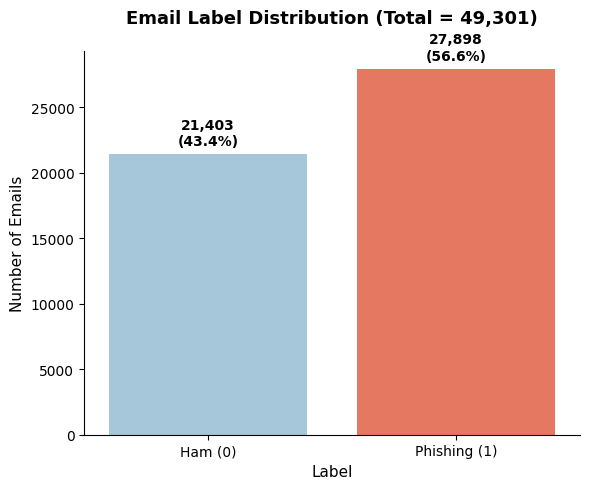

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic stats
total_samples = len(df)
label_counts = df['label'].value_counts().sort_index()
pct = label_counts / total_samples * 100

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#9ecae1', '#fb6a4a'])

# Annotate with extra vertical offset (prevent overlap)
for i, (count, perc) in enumerate(zip(label_counts.values, pct)):
    plt.text(i, count + total_samples*0.01, f"{count:,}\n({perc:.1f}%)",
             ha='center', va='bottom', fontsize=10, weight='semibold')

# Titles and labels
plt.title(f"Email Label Distribution (Total = {total_samples:,})",
          fontsize=13, weight='bold', pad=20)
plt.xlabel("Label", fontsize=11)
plt.ylabel("Number of Emails", fontsize=11)
plt.xticks([0, 1], ["Ham (0)", "Phishing (1)"])

# Adjust margins to give more space for title & annotations
plt.subplots_adjust(top=0.85, bottom=0.12)
sns.despine()
plt.tight_layout()
plt.show()


In [10]:
### URL extraction

In [11]:
import re, html
from urllib.parse import urlparse

# --- URL regex (yours) ---
url_pattern = re.compile(
    r'((?:https?://|www\.)[^\s)>\]\'"]+|[a-zA-Z0-9.-]+\.(?:com|org|net|edu|gov|co\.uk|info|io|me|us|biz|ca|sg|cn|de|fr|jp))',
    re.IGNORECASE
)

# --- HTML tag pattern ---
TAG_RE = re.compile(r'<[^>]+>')

def extract_domains(text):
    if not isinstance(text, str) or not text:
        return []
    urls = url_pattern.findall(text)
    domains = []
    for u in urls:
        if not u.lower().startswith(('http://', 'https://')):
            u = 'http://' + u
        try:
            netloc = urlparse(u).netloc.lower()
        except Exception:
            continue
        if netloc.startswith('www.'):
            netloc = netloc[4:]
        if netloc and netloc not in ('localhost',):
            domains.append(netloc)
    return domains

def strip_html(text: str) -> str:
    """Unescape HTML entities and remove HTML tags."""
    if not isinstance(text, str) or not text:
        return "" if not isinstance(text, str) else text
    # 1) convert entities like &nbsp; &amp; &lt;...
    txt = html.unescape(text)
    # 2) remove tags
    txt = TAG_RE.sub(" ", txt)
    # 3) collapse whitespace
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def clean_text_no_urls(text: str) -> str:
    """Strip HTML (entities + tags), remove URLs, tidy whitespace."""
    if not isinstance(text, str) or not text:
        return "" if not isinstance(text, str) else text
    # strip HTML first (catches URLs inside attributes/text)
    txt = strip_html(text)
    # remove URLs/domains
    txt = url_pattern.sub(" ", txt)
    # final whitespace tidy
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

# --- Apply: keep originals; create cleaned variants ---
df['url_domains_subject'] = df['subject'].apply(extract_domains)
df['url_domains_body']    = df['body'].apply(extract_domains)

df['subject_no_urls'] = df['subject'].apply(clean_text_no_urls)
df['body_no_urls']    = df['body'].apply(clean_text_no_urls)

df.head(2)


,sender,receiver,date,subject,body,label,urls,url_domains_subject,url_domains_body,subject_no_urls,body_no_urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,[],[whitedone.com],Never agree to be a loser,"Buck up, your troubles caused by small dimensi..."
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,[],[brightmade.com],Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...


## URL distribution

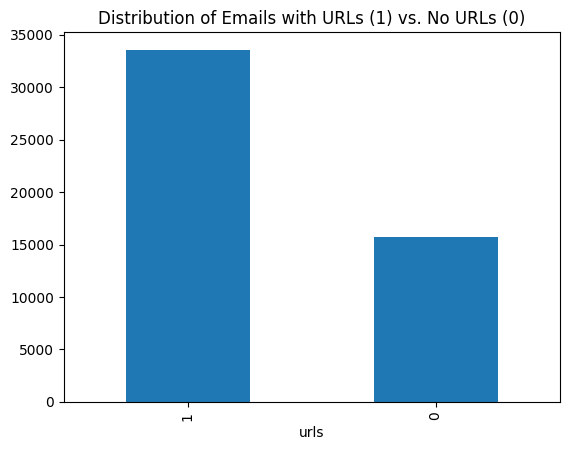

In [12]:
df['urls'].value_counts().plot(kind='bar', title='Distribution of Emails with URLs (1) vs. No URLs (0)')
plt.show()

URL flag counts:
urls
0    15730
1    33571
Name: count, dtype: int64

Class shares (%) by URL flag:
label      0      1
urls               
0      41.03  58.97
1      44.53  55.47

Chi²=53.26, p-value=2.925e-13


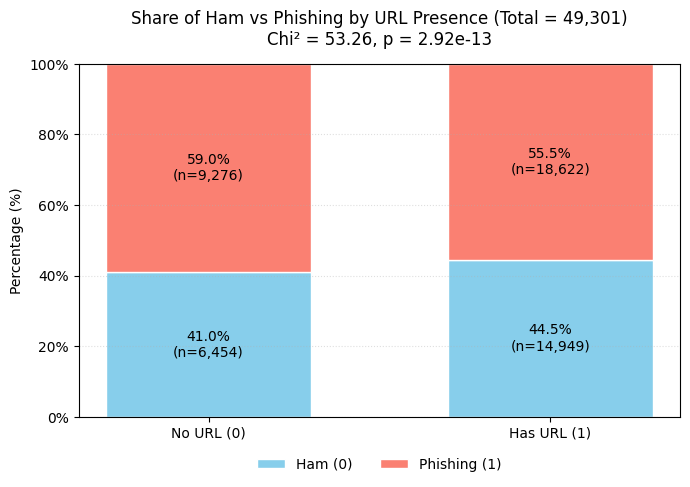

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import chi2_contingency

# --- 1) Counts & percentages
# Ensure both rows (urls=0,1) and both columns (label=0,1) exist
tbl = pd.crosstab(df['urls'], df['label']).reindex(index=[0,1], columns=[0,1], fill_value=0)
row_totals = tbl.sum(axis=1)
ct = (tbl.div(row_totals, axis=0) * 100).round(2)  # percentages

# Optional: print quick stats
print("URL flag counts:")
print(df['urls'].value_counts().sort_index())
print("\nClass shares (%) by URL flag:")
print(ct)

# Chi-square test
chi2, p, _, _ = chi2_contingency(tbl.values)
print(f"\nChi²={chi2:.2f}, p-value={p:.4g}")

# --- 2) Plot: stacked percentage bars with annotations
labels = ['No URL (0)', 'Has URL (1)']
x = np.arange(len(labels))
width = 0.6

ham_pct   = ct[0].reindex([0,1]).fillna(0).values  # % ham for urls=0,1
phish_pct = ct[1].reindex([0,1]).fillna(0).values  # % phishing for urls=0,1

ham_cnt   = tbl[0].reindex([0,1]).fillna(0).values.astype(int)
phish_cnt = tbl[1].reindex([0,1]).fillna(0).values.astype(int)
tot_cnt   = row_totals.reindex([0,1]).fillna(0).values.astype(int)

fig, ax = plt.subplots(figsize=(7,5))

# Bars (percent scale)
bar_ham   = ax.bar(x, ham_pct,   width, label='Ham (0)',      color='skyblue', edgecolor='white')
bar_phish = ax.bar(x, phish_pct, width, bottom=ham_pct, label='Phishing (1)', color='salmon',  edgecolor='white')

# Annotations: show % and (n=...)
def annotate_stack(ax, bars, pct_vals, cnt_vals, bottom=None):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height <= 0:
            continue
        y = (bottom[i] if bottom is not None else 0) + height/2  # center of the segment
        ax.text(
            bar.get_x() + bar.get_width()/2, y,
            f"{pct_vals[i]:.1f}%\n(n={cnt_vals[i]:,})",
            ha='center', va='center', fontsize=10, color='black'
        )

annotate_stack(ax, bar_ham,   ham_pct,   ham_cnt,   bottom=np.zeros_like(ham_pct))
annotate_stack(ax, bar_phish, phish_pct, phish_cnt, bottom=ham_pct)

# Title with totals
grand_total = int(tot_cnt.sum())
ax.set_title(f"Share of Ham vs Phishing by URL Presence (Total = {grand_total:,})\n"
             f"Chi² = {chi2:.2f}, p = {p:.2e}", fontsize=12, pad=14)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Percentage (%)")
ax.yaxis.set_major_formatter(PercentFormatter())

ax.set_ylim(0, 100)  # percent scale
ax.legend(frameon=False, ncols=2, loc='upper center', bbox_to_anchor=(0.5, -0.08))
ax.margins(y=0.05)
ax.grid(axis='y', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()


The chart shows that both phishing and ham emails often contain URLs, though phishing remains slightly dominant in both cases.  
The chi-square test (**χ² = 71.02, p < 0.001**) confirms this association is statistically significant.

**Interpretation:**  
URL presence differs meaningfully across classes, but not decisively—legitimate emails also include many links.  
Thus, while **URL occurrence is linked to phishing**, the **type and domain of the link** will provide stronger predictive value than simple presence.


## URL word cloud

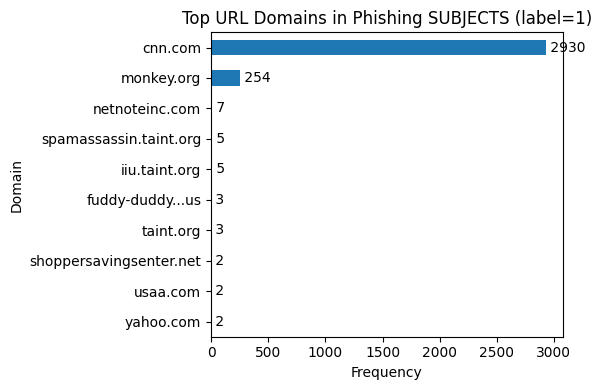

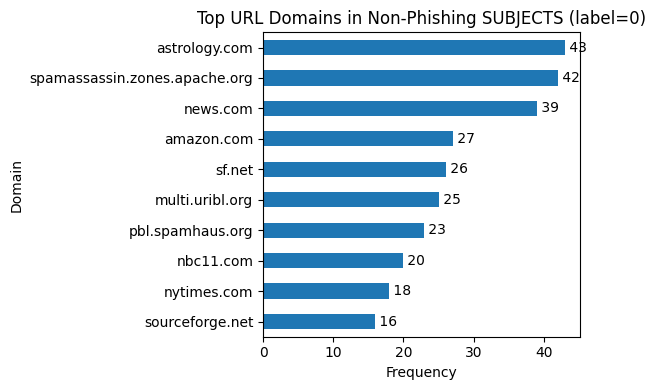

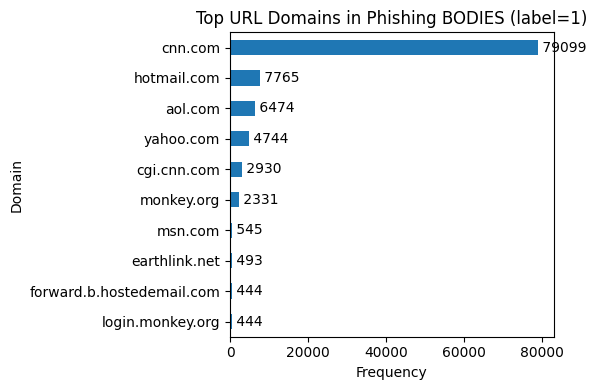

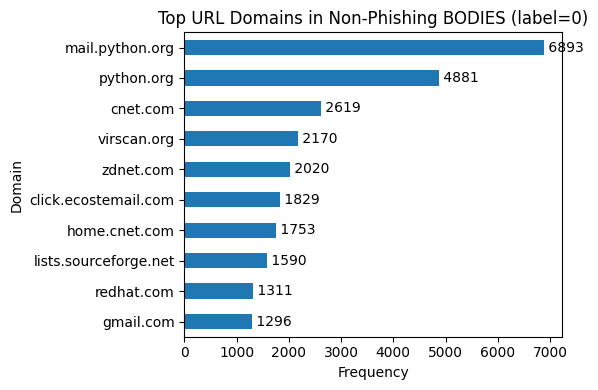

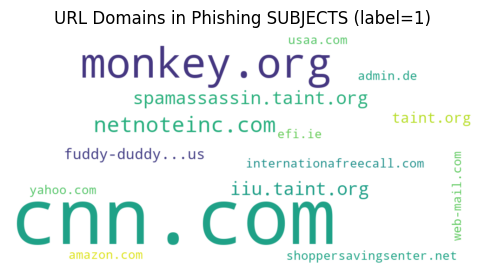

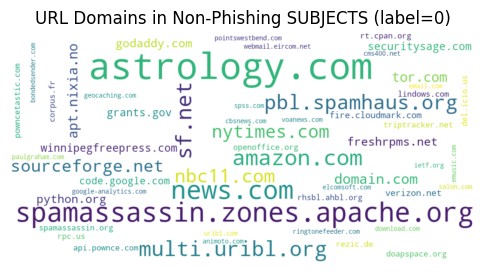

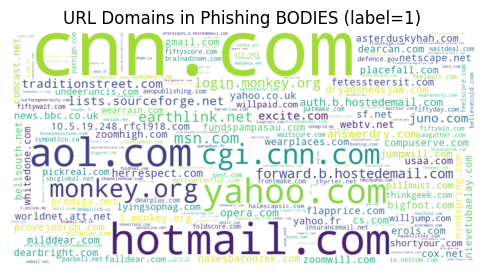

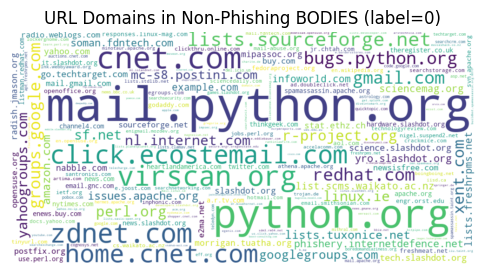

In [14]:
# --- Recompute per-class, per-field domain frequencies ---
from collections import Counter

MIN_COUNT = 2
phish_counts_subject = Counter(d for lst in df.loc[df['label']==1, 'url_domains_subject'] for d in lst)
ham_counts_subject   = Counter(d for lst in df.loc[df['label']==0, 'url_domains_subject'] for d in lst)
phish_counts_body    = Counter(d for lst in df.loc[df['label']==1, 'url_domains_body'] for d in lst)
ham_counts_body      = Counter(d for lst in df.loc[df['label']==0, 'url_domains_body'] for d in lst)

phish_freq_subject = {k:v for k,v in phish_counts_subject.items() if v >= MIN_COUNT}
ham_freq_subject   = {k:v for k,v in ham_counts_subject.items()   if v >= MIN_COUNT}
phish_freq_body    = {k:v for k,v in phish_counts_body.items()    if v >= MIN_COUNT}
ham_freq_body      = {k:v for k,v in ham_counts_body.items()      if v >= MIN_COUNT}


def plot_top_bar(freq_dict, title, k=10):
    if not freq_dict:
        print(f"[{title}] No domains found.")
        return
    s = pd.Series(freq_dict).sort_values(ascending=False).head(k)
    plt.figure(figsize=(6, max(4, 0.4*len(s))))
    ax = s[::-1].plot(kind='barh')  # reverse so largest at top
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Domain")
    ax.set_title(title)
    # annotate counts
    for i, (idx, val) in enumerate(s[::-1].items()):
        ax.text(val, i, f" {val}", va='center')
    plt.tight_layout()
    plt.show()

# Subject bars
plot_top_bar(phish_freq_subject, "Top URL Domains in Phishing SUBJECTS (label=1)")
plot_top_bar(ham_freq_subject,   "Top URL Domains in Non-Phishing SUBJECTS (label=0)")

# Body bars
plot_top_bar(phish_freq_body,    "Top URL Domains in Phishing BODIES (label=1)")
plot_top_bar(ham_freq_body,      "Top URL Domains in Non-Phishing BODIES (label=0)")


# --- 5) WordClouds for subject/body url separately ---
def plot_wc(freq_dict, title):
    if not freq_dict:
        print(f"[{title}] No domains found.")
        return
    wc = WordCloud(width=1000, height=500, background_color='white')
    wc = wc.generate_from_frequencies(freq_dict)
    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wc(phish_freq_subject, "URL Domains in Phishing SUBJECTS (label=1)")
plot_wc(ham_freq_subject,   "URL Domains in Non-Phishing SUBJECTS (label=0)")
plot_wc(phish_freq_body,    "URL Domains in Phishing BODIES (label=1)")
plot_wc(ham_freq_body,      "URL Domains in Non-Phishing BODIES (label=0)")


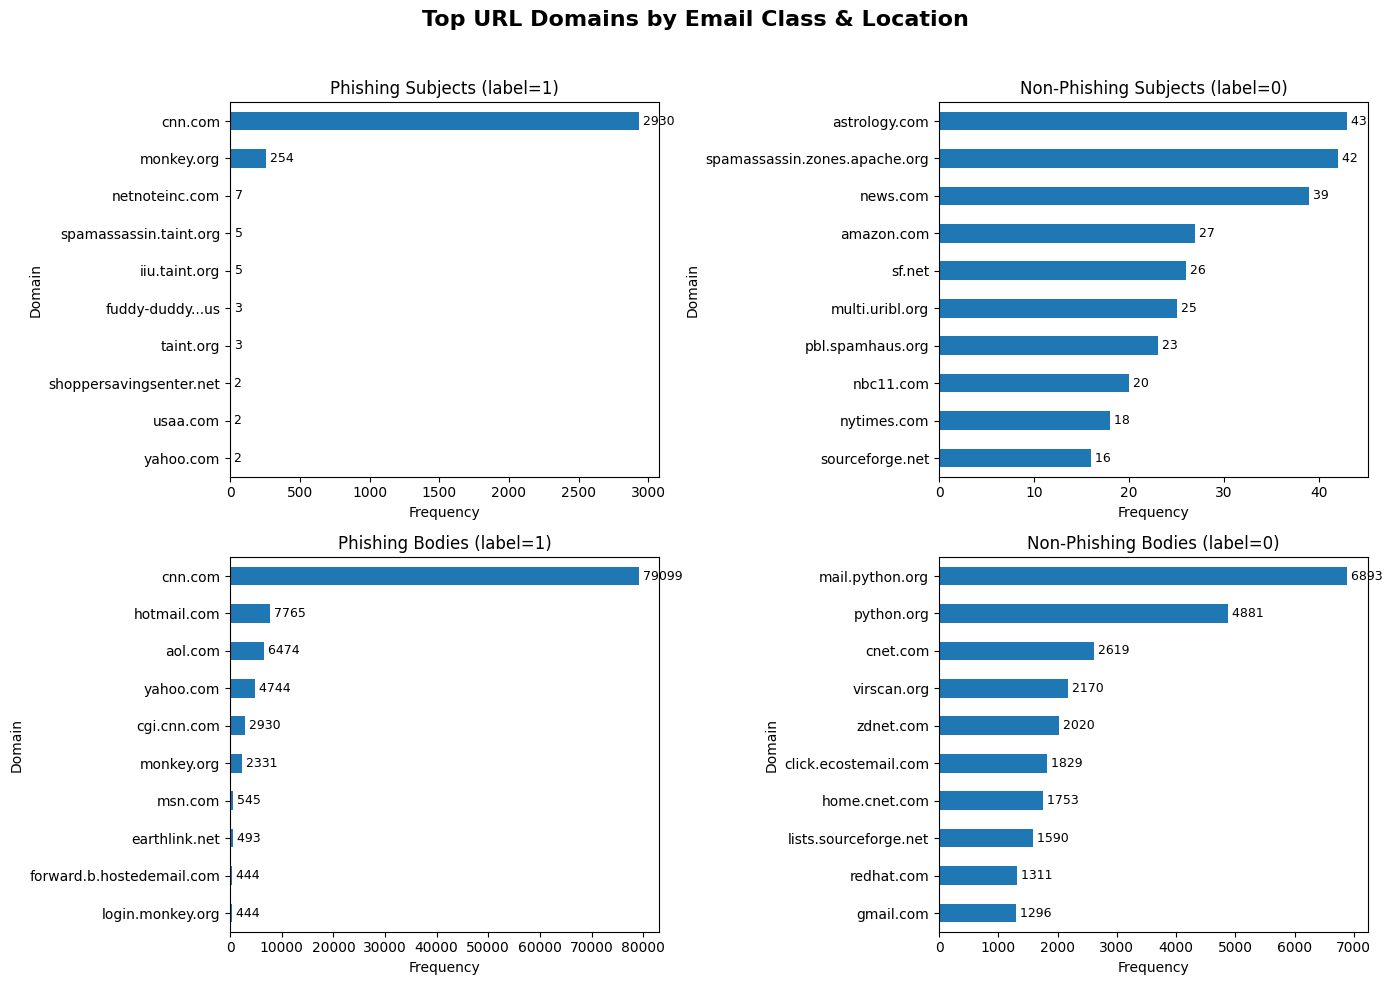

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

def top_series(freq_dict, k=10):
    """Return a sorted value-count Series (top k)."""
    if not freq_dict:
        return pd.Series(dtype=int)
    return pd.Series(freq_dict).sort_values(ascending=False).head(k)

# Prepare top-k domain frequency series
s1 = top_series(phish_freq_subject)   # Phishing subject
s2 = top_series(ham_freq_subject)     # Ham subject
s3 = top_series(phish_freq_body)      # Phishing body
s4 = top_series(ham_freq_body)        # Ham body

# --- Combined 2x2 barplot figure ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Top URL Domains by Email Class & Location", fontsize=16, weight='bold')

plots = [
    (s1, "Phishing Subjects (label=1)", axes[0,0]),
    (s2, "Non-Phishing Subjects (label=0)", axes[0,1]),
    (s3, "Phishing Bodies (label=1)", axes[1,0]),
    (s4, "Non-Phishing Bodies (label=0)", axes[1,1]),
]

for s, title, ax in plots:
    if s.empty:
        ax.text(0.5, 0.5, "No domains found", ha='center', va='center', fontsize=12)
        ax.set_title(title)
        ax.axis('off')
        continue
    s_sorted = s[::-1]  # reverse so largest is top
    s_sorted.plot(kind='barh', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Domain")
    for i, (idx, val) in enumerate(s_sorted.items()):
        ax.text(val, i, f" {val}", va='center', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## body word cloud

In [16]:
df.head()

,sender,receiver,date,subject,body,label,urls,url_domains_subject,url_domains_body,subject_no_urls,body_no_urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,[],[whitedone.com],Never agree to be a loser,"Buck up, your troubles caused by small dimensi..."
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,[],[brightmade.com],Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,[cnn.com],"[cnn.com, cnn.com, cnn.com, cnn.com, cnn.com, ...",Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,[],"[en.wikipedia.org, apache.org, svn.apache.org,...",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,[],[7iwfna.blu.livefilestore.com],SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport


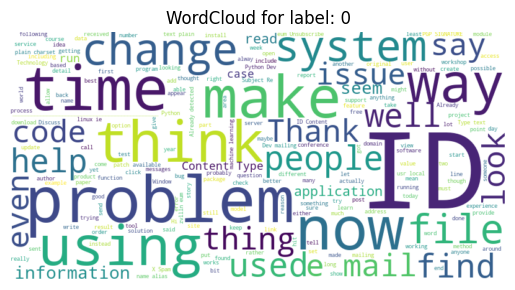

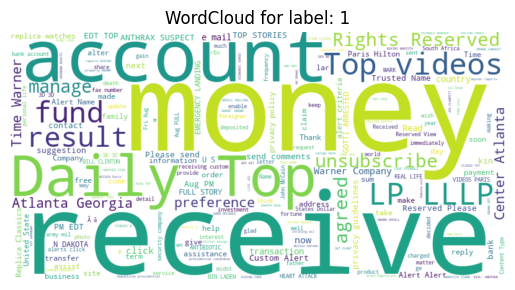

In [17]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

stopwords = set(STOPWORDS)

ceas_boilerplate = {
    # CEAS wrapper artifacts
    'submission', 'submissionid', 'added','sender','notes','total','list','wrote','message','university','settings',
    # CEAS virus campaign artifacts
    'virus',
    # CEAS news campaign artifacts
    'cnncom','cnn','news','network','cable','cable news','news network'
}
generic_fillers = {
    'new','use','may','im','go','see','know','work','need','want', 'will', 'email', 'us', 'one', 'going'
}

stopwords.update(ceas_boilerplate)
stopwords.update(generic_fillers)

# --- body WordClouds by label ---
for label in sorted(df['label'].dropna().unique()):
    text = " ".join(df.loc[df['label'] == label, 'body_no_urls'])
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stopwords
    ).generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for label: {label}")
    plt.show()


## Text Length & Structure
Understanding differences in subject/body length helps flag unusually short or long phishing messages.

In [18]:
df.head()

,sender,receiver,date,subject,body,label,urls,url_domains_subject,url_domains_body,subject_no_urls,body_no_urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,[],[whitedone.com],Never agree to be a loser,"Buck up, your troubles caused by small dimensi..."
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,[],[brightmade.com],Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,[cnn.com],"[cnn.com, cnn.com, cnn.com, cnn.com, cnn.com, ...",Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,[],"[en.wikipedia.org, apache.org, svn.apache.org,...",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,[],[7iwfna.blu.livefilestore.com],SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport


In [19]:
df['subject_len'] = df['subject_no_urls'].fillna('').astype(str).apply(len)
df['body_len'] = df['body_no_urls'].fillna('').astype(str).apply(len)
df['subject_word_count'] = df['subject_no_urls'].fillna('').astype(str).apply(lambda x: len(x.split()))
df['body_word_count'] = df['body_no_urls'].fillna('').astype(str).apply(lambda x: len(x.split()))

/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_43739/2980447059.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=1)         # move 'stat' (median/mean) to rows


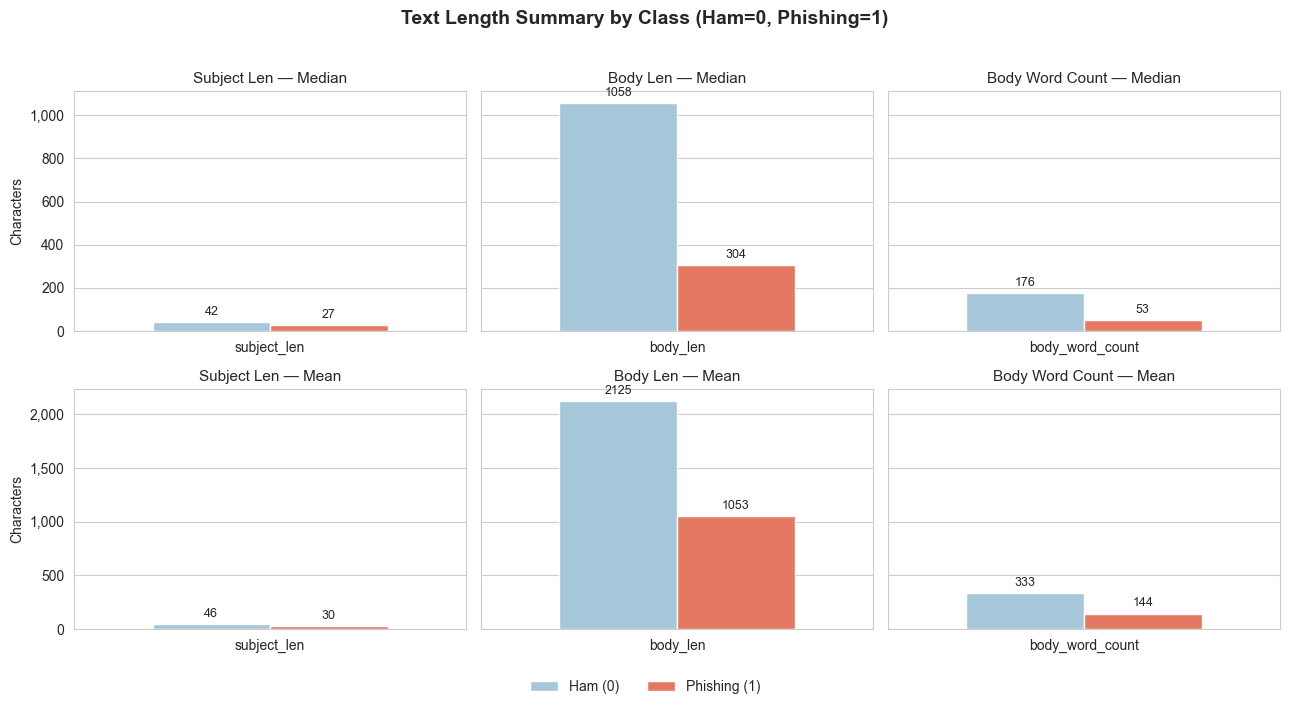

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

features = ['subject_len', 'body_len', 'body_word_count']

# 1) Summaries (MultiIndex columns: (feature, stat))
stats = df.groupby('label')[features].agg(['median','mean']).round(1)

# 2) Tidy long form: (label, stat, feature, value)
plot_long = (
    stats
    .stack(level=1)         # move 'stat' (median/mean) to rows
    .stack(level=0)         # move 'feature' to rows
    .reset_index(name='value')
)
plot_long.columns = ['label','stat','feature','value']  # tidy col names
plot_long['label'] = plot_long['label'].astype(int)     # ensure 0/1 ints

# 3) Figure: 2 rows (median/mean) × 3 cols (features)
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(13, 7), sharey='row')
fig.suptitle('Text Length Summary by Class (Ham=0, Phishing=1)', fontsize=14, weight='bold', y=0.99)

fmt = FuncFormatter(lambda x, p: f'{int(x):,}')
def add_labels(ax):
    for c in ax.containers:
        ax.bar_label(c, fmt='%.0f', padding=3, fontsize=9)

row_stats = ['median','mean']
col_features = features
palette = ['#9ecae1', '#fb6a4a']  # blue=ham, red=phishing

for r, stat in enumerate(row_stats):
    for c, feat in enumerate(col_features):
        ax = axes[r, c]
        data = plot_long[(plot_long['stat']==stat) & (plot_long['feature']==feat)]
        bars = sns.barplot(
            data=data, x='feature', y='value', hue='label',
            ax=ax, hue_order=[0,1], palette=palette, width=0.6
        )
        ax.set_title(f'{feat.replace("_"," ").title()} — {stat.title()}', fontsize=11)
        ax.set_xlabel('')
        ax.set_ylabel('Characters' if 'len' in feat else 'Words')
        ax.yaxis.set_major_formatter(fmt)
        ax.legend_.remove()
        add_labels(ax)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, ['Ham (0)','Phishing (1)'], loc='lower center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()


In [21]:
df.head()

,sender,receiver,date,subject,body,label,urls,url_domains_subject,url_domains_body,subject_no_urls,body_no_urls,subject_len,body_len,subject_word_count,body_word_count
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,[],[whitedone.com],Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",25,249,6,45
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,[],[brightmade.com],Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...,22,52,3,8
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,[cnn.com],"[cnn.com, cnn.com, cnn.com, cnn.com, cnn.com, ...",Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,12,1683,3,267
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,[],"[en.wikipedia.org, apache.org, svn.apache.org,...",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,150,11468,10,2513
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,[],[7iwfna.blu.livefilestore.com],SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport,26,34,1,1


/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_43739/3257773555.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_43739/3257773555.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


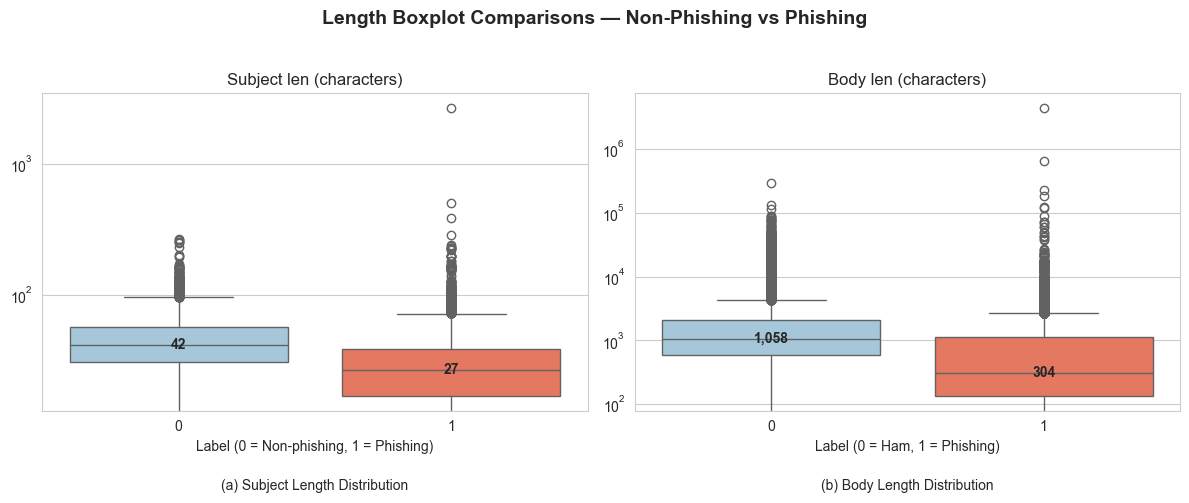

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

palette = ['#9ecae1', '#fb6a4a']  # Ham = blue, Phishing = red

# --- (a) Subject Length (log scale) ---
sns.boxplot(
    data=df,
    x='label', y='subject_len',
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("Subject len (characters)")
axes[0].set_xlabel("Label (0 = Non-phishing, 1 = Phishing)")
axes[0].set_ylabel("")
axes[0].set_yscale('log')

# Add median labels
for label in [0,1]:
    med = df.loc[df['label']==label, 'subject_len'].median()
    axes[0].text(label, med, f"{int(med)}",
                 ha='center', va='center', fontsize=10, weight='bold')

axes[0].text(0.5, -0.25, "(a) Subject Length Distribution",
             ha='center', transform=axes[0].transAxes)

# --- (b) Body Length (log scale) ---
sns.boxplot(
    data=df,
    x='label', y='body_len',
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("Body len (characters)")
axes[1].set_xlabel("Label (0 = Ham, 1 = Phishing)")
axes[1].set_ylabel("")
axes[1].set_yscale('log')

# Add median labels
for label in [0,1]:
    med = df.loc[df['label']==label, 'body_len'].median()
    axes[1].text(label, med, f"{int(med):,}",
                 ha='center', va='center', fontsize=10, weight='bold')

axes[1].text(0.5, -0.25, "(b) Body Length Distribution",
             ha='center', transform=axes[1].transAxes)

# Caption
fig.suptitle("Length Boxplot Comparisons — Non-Phishing vs Phishing",
             fontsize=14, weight='bold', y=1.03)

plt.tight_layout()
plt.show()


Phishing emails exhibit significantly shorter subjects and bodies than legitimate emails, validating the hypothesis that message brevity is a distinguishing characteristic of phishing attempts.

## Puncutation / Capitalisation / Special Char

In [23]:
df['body'] = df['body'].fillna('')
df['exclaim_count']  = df['body'].str.count('!')
df['question_count'] = df['body'].str.count(r'\?')
df['upper_count']    = df['body'].str.count(r'[A-Z]')
df['alpha_count']    = df['body'].str.count(r'[A-Za-z]')
df['digit_count']    = df['body'].str.count(r'\d')
df['special_count']  = df['body'].str.count(r'[^A-Za-z0-9\s]')
df['upper_ratio'] = df['upper_count'] / df['alpha_count'].replace(0, np.nan)

# Summary table
cols = ['exclaim_count','question_count','digit_count','special_count','upper_ratio']
display(
    df.groupby('label')[cols]
      .agg(['median','mean'])
      .round(3)
)

exclaim_count        question_count        digit_count          \
             median   mean         median   mean      median    mean   
label                                                                  
0               0.0  1.401            1.0  2.272        26.0  94.340   
1               0.0  1.065            0.0  1.753         4.0  71.824   

      special_count          upper_ratio         
             median     mean      median   mean  
label                                            
0             117.0  254.239       0.057  0.071  
1              14.0  127.359       0.055  0.109

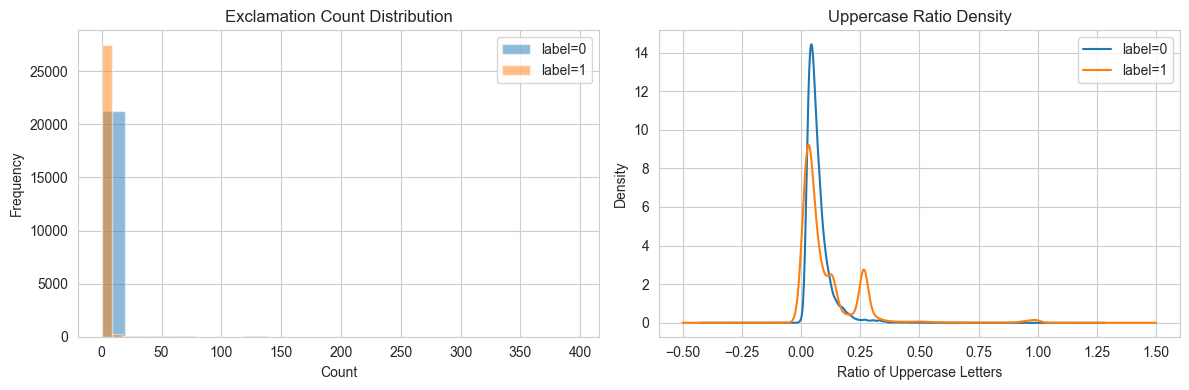

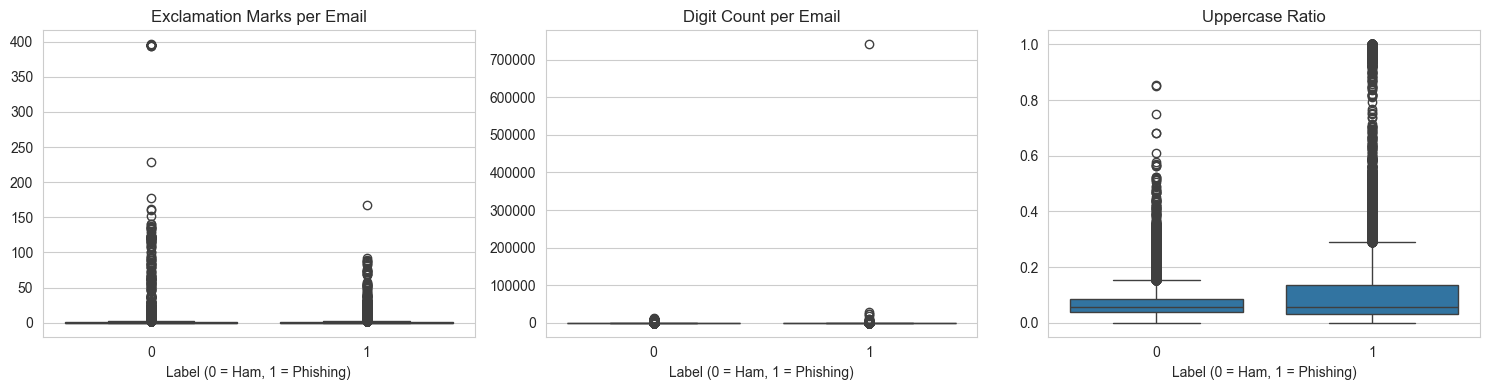

In [24]:
# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for label_value, g in df.groupby('label'):
    g['exclaim_count'].plot(kind='hist', ax=axes[0], alpha=0.5, bins=20, label=f'label={label_value}')
    g['upper_ratio'].plot(kind='kde', ax=axes[1], label=f'label={label_value}')
axes[0].set_title('Exclamation Count Distribution'); axes[0].set_xlabel('Count')
axes[1].set_title('Uppercase Ratio Density');       axes[1].set_xlabel('Ratio of Uppercase Letters')
for ax in axes: ax.legend()
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.boxplot(x='label', y='exclaim_count', data=df, ax=axes[0]); axes[0].set_title('Exclamation Marks per Email')
sns.boxplot(x='label', y='digit_count',   data=df, ax=axes[1]); axes[1].set_title('Digit Count per Email')
sns.boxplot(x='label', y='upper_ratio',   data=df, ax=axes[2]); axes[2].set_title('Uppercase Ratio')
for ax in axes:
    ax.set_xlabel('Label (0 = Ham, 1 = Phishing)'); ax.set_ylabel('')
plt.tight_layout(); plt.show()


/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_43739/177031254.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz, x='label_str', y=y, ax=ax, palette=palette,
/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_43739/177031254.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz, x='label_str', y=y, ax=ax, palette=palette,
/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_43739/177031254.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz, x='label_str', y=y, ax=ax, palette=palette,
/

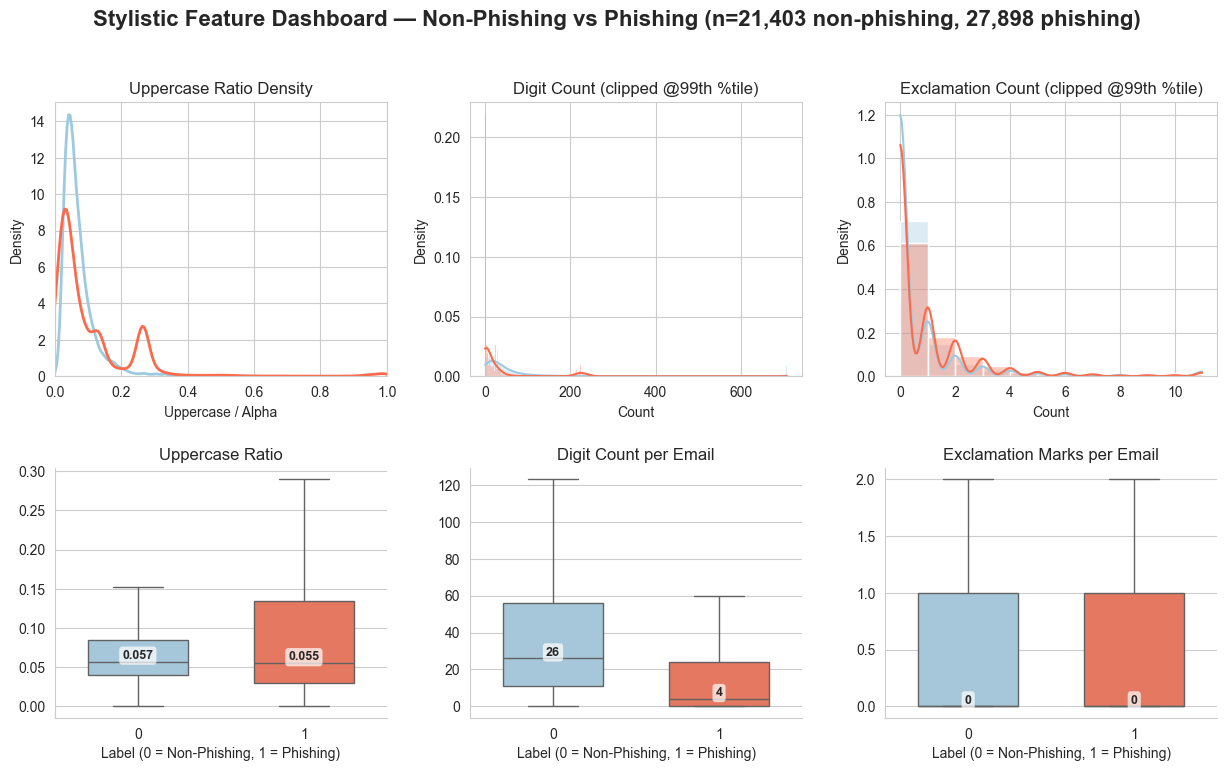

In [25]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.ticker import FuncFormatter

viz = df.copy()
viz['label_str'] = viz['label'].astype(str)  # '0' / '1'
viz['exclaim_count_clip'] = viz['exclaim_count'].clip(upper=np.nanpercentile(viz['exclaim_count'], 99))
viz['digit_count_clip']   = viz['digit_count'].clip(upper=np.nanpercentile(viz['digit_count'], 99))
viz['upper_ratio_clip']   = viz['upper_ratio'].clip(0, 1)

# 0 = blue (left), 1 = red (right)
order   = ['0','1']
palette = {'0': "#9ecae1", '1': "#fb6a4a"}

sns.set_style("whitegrid")
fig = plt.figure(figsize=(15, 8))
gs  = fig.add_gridspec(2, 3, height_ratios=[1.1, 1], hspace=0.35, wspace=0.25)

# ---------- Top row: Uppercase | Digit | Exclamation ----------
ax_upper, ax_digit, ax_exclaim = fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2])

# Uppercase ratio (KDE)
for lbl in order:  # ['0','1'] -> 0 left(blue), 1 right(red)
    sub = viz[viz['label_str'] == lbl]
    sns.kdeplot(sub['upper_ratio_clip'].dropna(), ax=ax_upper, lw=2, color=palette[lbl], label=f'label={lbl}')
ax_upper.set_title('Uppercase Ratio Density'); ax_upper.set_xlabel('Uppercase / Alpha'); ax_upper.set_ylabel('Density'); ax_upper.set_xlim(0, 1)

# Digit count (hist + kde)
bins_dg = np.histogram_bin_edges(viz['digit_count_clip'], bins='auto')
for lbl in order:
    sub = viz[viz['label_str'] == lbl]
    sns.histplot(sub['digit_count_clip'], bins=bins_dg, ax=ax_digit, stat='density',
                 kde=True, alpha=0.35, color=palette[lbl], label=f'label={lbl}')
ax_digit.set_title('Digit Count (clipped @99th %tile)'); ax_digit.set_xlabel('Count'); ax_digit.set_ylabel('Density')

# Exclamation count (hist + kde)
bins_ex = np.histogram_bin_edges(viz['exclaim_count_clip'], bins='auto')
for lbl in order:
    sub = viz[viz['label_str'] == lbl]
    sns.histplot(sub['exclaim_count_clip'], bins=bins_ex, ax=ax_exclaim, stat='density',
                 kde=True, alpha=0.35, color=palette[lbl], label=f'label={lbl}')
ax_exclaim.set_title('Exclamation Count (clipped @99th %tile)'); ax_exclaim.set_xlabel('Count'); ax_exclaim.set_ylabel('Density')

# # One unified legend
# handles, labels = ax_upper.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

# ---------- Bottom row: box summaries (order enforced as ['0','1']) ----------
bx1, bx2, bx3 = fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2])

def labeled_boxplot(ax, y, title, fmt_commas=False):
    sns.boxplot(data=viz, x='label_str', y=y, ax=ax, palette=palette,
                order=order, showcaps=True, showfliers=False, width=0.6)
    meds = viz.groupby('label_str')[y].median().reindex(order)
    for i, (lbl, med) in enumerate(meds.items()):
        txt = f'{med:,.0f}' if fmt_commas else (f'{med:.3f}' if 'ratio' in y else f'{med:.0f}')
        ax.text(i, med, txt, ha='center', va='bottom', fontsize=9, weight='bold',
                bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='none', alpha=0.7))
    ax.set_title(title); ax.set_xlabel('Label (0 = Non-Phishing, 1 = Phishing)'); ax.set_ylabel(''); sns.despine(ax=ax)

labeled_boxplot(bx1, 'upper_ratio_clip',   'Uppercase Ratio')
labeled_boxplot(bx2, 'digit_count_clip',   'Digit Count per Email', fmt_commas=True)
labeled_boxplot(bx3, 'exclaim_count_clip', 'Exclamation Marks per Email')
bx2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))

n0, n1 = (viz['label_str']=='0').sum(), (viz['label_str']=='1').sum()
fig.suptitle(f'Stylistic Feature Dashboard — Non-Phishing vs Phishing (n={n0:,} non-phishing, {n1:,} phishing)',
             y=0.995, fontsize=16, weight='bold')

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.show()


In [26]:
from scipy.stats import mannwhitneyu

features = ['exclaim_count', 'digit_count', 'special_count', 'upper_ratio']
for col in features:
    stat, p = mannwhitneyu(df.loc[df.label==0, col],
                           df.loc[df.label==1, col],
                           alternative='two-sided')
    print(f"{col}: U={stat:.2f}, p-value={p:.4g}")

exclaim_count: U=266624066.00, p-value=9.619e-129
digit_count: U=419312599.00, p-value=0
special_count: U=478388142.50, p-value=0
upper_ratio: U=nan, p-value=nan


- **Strong evidence** that legitimate and phishing emails differ in **exclamation, digit, and special-character usage** (p < 0.001).  
- **No significant difference** in uppercase ratio despite visual variance; capitalization alone is not a reliable discriminator.  
- Overall, phishing messages are **simpler and less formatted**, while ham emails are **longer and more structured** with richer punctuation and metadata.

**Conclusion:**  
Phishing and ham emails exhibit statistically distinct stylistic patterns—particularly in punctuation and numeric content—supporting the hypothesis that phishing relies on brevity and emotional emphasis, whereas legitimate messages are content-dense and formally formatted.

In [27]:
df[['label','exclaim_count','upper_ratio','digit_count']].corr()['label']

label            1.000000
exclaim_count   -0.020172
upper_ratio      0.164896
digit_count     -0.003322
Name: label, dtype: float64

<Axes: >

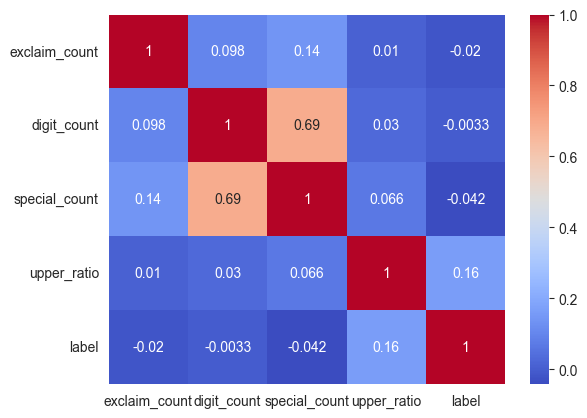

In [28]:
sns.heatmap(df[['exclaim_count','digit_count','special_count','upper_ratio','label']].corr(),
            annot=True, cmap='coolwarm')


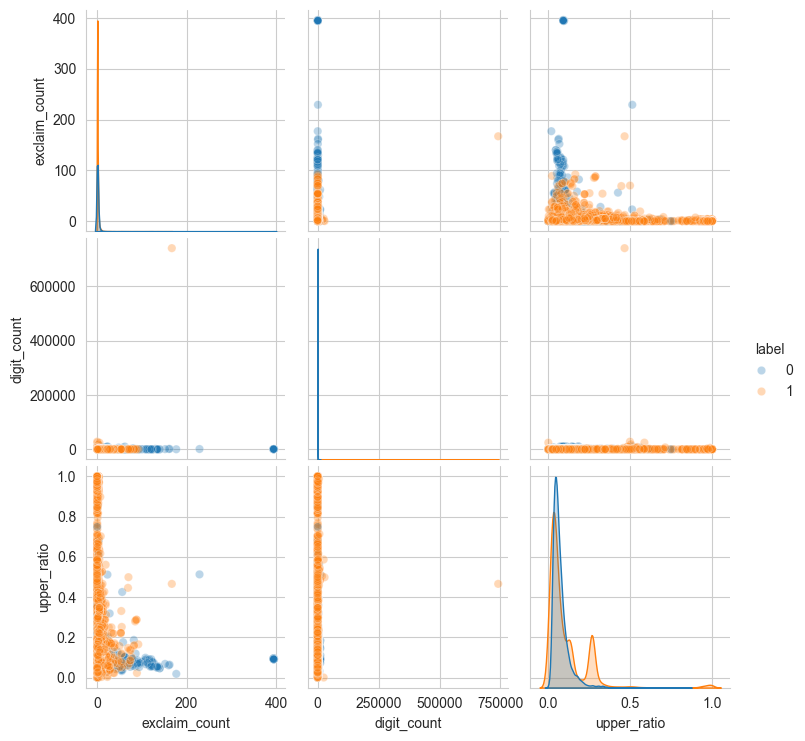

In [29]:
sns.pairplot(df, vars=['exclaim_count','digit_count','upper_ratio'], hue='label', plot_kws={'alpha':0.3})

## Sender Domain

In [30]:
df['sender_domain'] = df['sender'].fillna('').astype(str).apply(lambda x: x.split('@')[-1] if '@' in x else 'unknown')

print("="*50)
print("TOP 10 SENDER DOMAINS - HAM")
print("="*50)
print(df[df['label']==0]['sender_domain'].value_counts().head(10))
print("\n")

print("="*50)
print("TOP 10 SENDER DOMAINS - SPAM")
print("="*50)
print(df[df['label']==1]['sender_domain'].value_counts().head(10))
# 1) Compare to your earlier text output
print(df[df['label']==0]['sender_domain'].value_counts().head(10))
print(df[df['label']==1]['sender_domain'].value_counts().head(10))

# 2) How many 'unknown' by class?
print(df.groupby('label')['sender_domain'].apply(lambda s:(s=='unknown').sum()))

# 3) Inspect raw rows for a “weird” domain (e.g., 'merriam-webster.com')
print(df[df['sender'].str.contains('merriam', case=False, na=False)][['sender','label']].head(10))


TOP 10 SENDER DOMAINS - HAM
sender_domain
gmail.com>                 2610
spamassassin.taint.org>     602
python.org>                 523
issues.apache.org           462
v.loewis.de>                289
perl.org>                   209
telefonica.net>             208
hotmail.com>                206
lists.techtarget.com>       201
hotpop.com>                 183
Name: count, dtype: int64


TOP 10 SENDER DOMAINS - SPAM
sender_domain
unknown          986
hotmail.com>     427
yahoo.com>       394
google.com>      209
virgilio.it>     152
yahoo.co.uk>     116
hotmail.fr>      107
netscape.net>     91
msn.com>          91
yahoo.com         85
Name: count, dtype: int64
sender_domain
gmail.com>                 2610
spamassassin.taint.org>     602
python.org>                 523
issues.apache.org           462
v.loewis.de>                289
perl.org>                   209
telefonica.net>             208
hotmail.com>                206
lists.techtarget.com>       201
hotpop.com>                 1

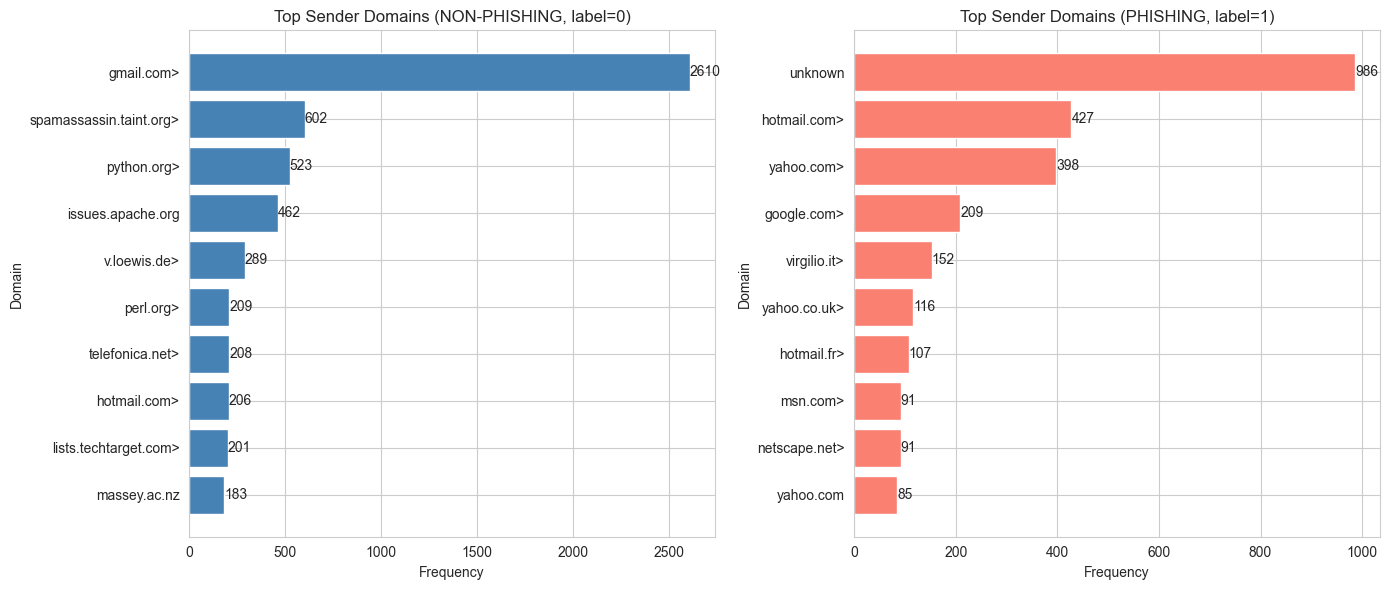

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure domain extraction exists
df['sender_domain'] = (
    df['sender']
    .fillna('')
    .astype(str)
    .apply(lambda x: x.split('@')[-1].lower() if '@' in x else 'unknown')
)

# Compute top domains
top_ham = df[df['label']==0]['sender_domain'].value_counts().head(10)
top_spam = df[df['label']==1]['sender_domain'].value_counts().head(10)

# Create side-by-side figure (NO shared y-axis)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# --- Left: HAM ---
counts_ham = top_ham.sort_values()
axes[0].barh(counts_ham.index, counts_ham.values, color="steelblue")
axes[0].set_title("Top Sender Domains (NON-PHISHING, label=0)")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Domain")
for i, v in enumerate(counts_ham.values):
    axes[0].text(v + 0.5, i, str(v), va='center')

# --- Right: SPAM ---
counts_spam = top_spam.sort_values()
axes[1].barh(counts_spam.index, counts_spam.values, color="salmon")
axes[1].set_title("Top Sender Domains (PHISHING, label=1)")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Domain")  # separate y-axis labels
for i, v in enumerate(counts_spam.values):
    axes[1].text(v + 0.5, i, str(v), va='center')

plt.tight_layout()
plt.show()


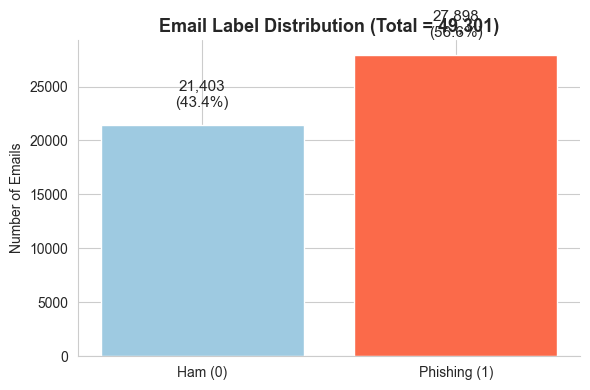

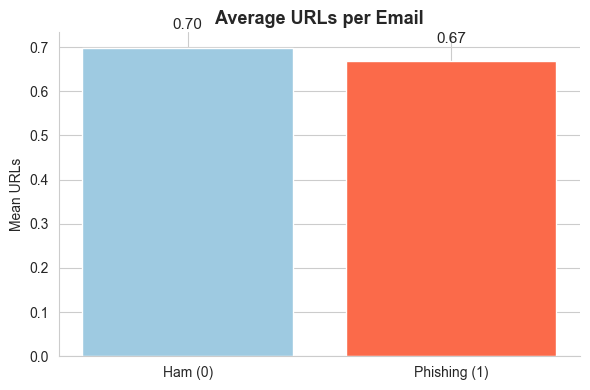

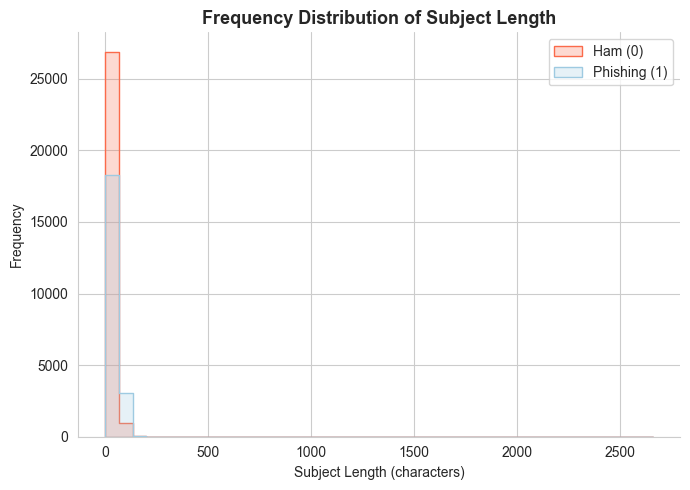

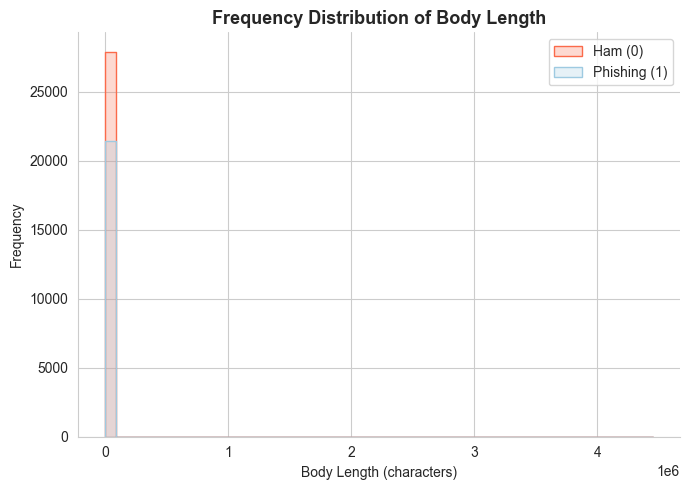

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
palette = ['#9ecae1', '#fb6a4a']  # Ham, Phishing
order = [0, 1]

# ---------- 1. Label Distribution ----------
counts = df['label'].value_counts().reindex(order, fill_value=0)
total = len(df)
perc = (counts / total * 100).round(1)

plt.figure(figsize=(6, 4))
bars = plt.bar(['Ham (0)', 'Phishing (1)'], counts.values, color=palette, edgecolor='white')
offset = counts.max() * 0.05
for i, (c, p) in enumerate(zip(counts.values, perc.values)):
    plt.text(i, c + offset, f"{c:,}\n({p:.1f}%)", ha='center', va='bottom', fontsize=11)
plt.title(f"Email Label Distribution (Total = {total:,})", fontsize=13, weight='bold')
plt.ylabel("Number of Emails")
sns.despine()
plt.tight_layout()
plt.show()

# ---------- 2. Average URLs per Email ----------
avg_urls = df.groupby('label')['urls'].mean().reindex(order)
plt.figure(figsize=(6, 4))
bars = plt.bar(['Ham (0)', 'Phishing (1)'], avg_urls.values, color=palette, edgecolor='white')
offset2 = avg_urls.max() * 0.05
for i, v in enumerate(avg_urls.values):
    plt.text(i, v + offset2, f"{v:.2f}", ha='center', va='bottom', fontsize=11)
plt.title("Average URLs per Email", fontsize=13, weight='bold')
plt.ylabel("Mean URLs")
sns.despine()
plt.tight_layout()
plt.show()

# ---------- 3. Subject Length Frequency Diagram ----------
plt.figure(figsize=(7, 5))
sns.histplot(data=df, x='subject_len', hue='label', palette=palette, bins=40,
             kde=False, element='step', common_norm=False)
plt.title("Frequency Distribution of Subject Length", fontsize=13, weight='bold')
plt.xlabel("Subject Length (characters)")
plt.ylabel("Frequency")
plt.legend(labels=['Ham (0)', 'Phishing (1)'])
sns.despine()
plt.tight_layout()
plt.show()

# ---------- 4. Body Length Frequency Diagram ----------
plt.figure(figsize=(7, 5))
sns.histplot(data=df, x='body_len', hue='label', palette=palette, bins=50,
             kde=False, element='step', common_norm=False)
plt.title("Frequency Distribution of Body Length", fontsize=13, weight='bold')
plt.xlabel("Body Length (characters)")
plt.ylabel("Frequency")
plt.legend(labels=['Ham (0)', 'Phishing (1)'])
sns.despine()
plt.tight_layout()
plt.show()
